In [3]:
%reload_ext autoreload
%autoreload 2
# %load_ext wurlitzer

import sys
sys.path.append("../")

import numpy as np
import time
from utils import model
from inference import logmarglik
from inference import zstates as zs
from utils import hyperparameters
from iotools import snp_annotator

import matplotlib.pyplot as plt
import utils.mpl_stylesheet as mplstyle

mplstyle.banskt_presentation()

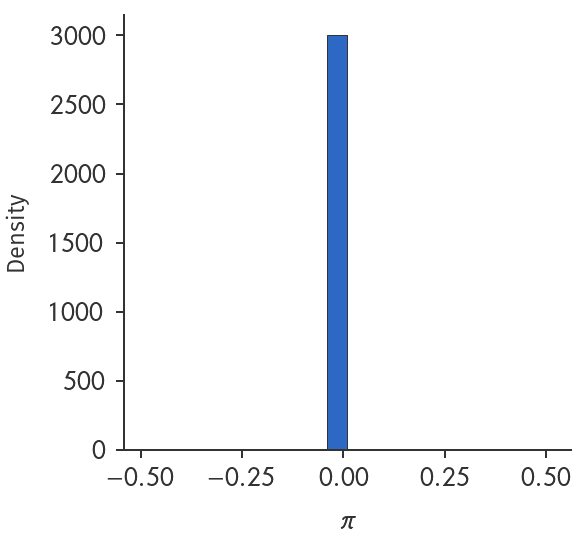

Creating phenotype with sigma 0.01, heritability 0.00438991, sigma_tau 0.997803
Using 34 causal SNPs


In [4]:
nsample = 500
nsnps = 3000
pi = 0.01
mu = 0.0
sigmabg = 0.0
sigma = 0.01

# No feature
features = np.ones((nsnps, 1))

# Add a random feature
#myfeat = np.zeros((nsnps, 1))
#myfeat[np.random.permutation(np.arange(nsnps))[:int(nsnps / 4)]] = 1
#features = np.concatenate((features, myfeat), axis=1)

# Add distance feature
# dist = np.linspace(-40000, 40000, nsnps)
# distfeat = snp_annotator.myTcurve(dist)
# distfeat = 1 / distfeat
distfeat = np.ones(nsnps)

# Create gamma
gamma = np.zeros(features.shape[1])
gamma[0] = - np.log((1 / pi) - 1)
#enrich = 2
#gval = np.log(enrich) - np.log(1 + (1 - enrich) * np.exp(gamma[0]))
#
#gamma[1:] = np.repeat(gval, features.shape[1] - 1)

x, y, csnps, v = model.simulate(nsample, nsnps, 
                                features, 1 / distfeat, gamma,
                                mu = mu,
                                sigma = sigma,
                                sigmabg = sigmabg,)

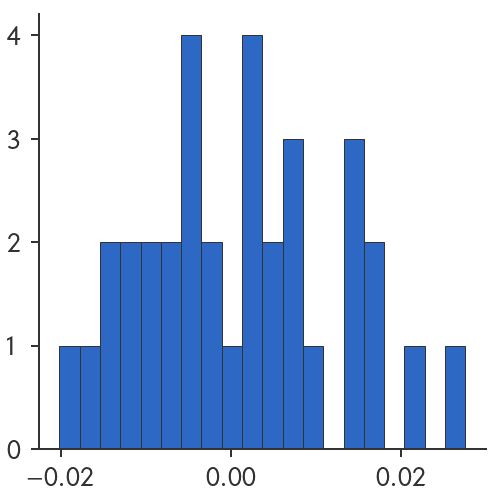

In [5]:
plt.figure()
plt.hist(v[csnps])
plt.show()

In [6]:
tau = 1 / (1 - np.sum(np.square(v[csnps])))
params = np.append(gamma, [mu, sigma, sigmabg, tau])
# scaledparams = hyperparameters.scale(params)
# cmax = 1
# zstates = zs.create(scaledparams, x, y, features, distfeat, cmax, nsnps, 0.98)
zstates = [[]] + list([i] for i in csnps)

In [ ]:
# Plot for sigma

sigmavals = np.logspace(-3, -1, num = 10, base = 10)
lml = np.zeros_like(sigmavals)
nfeat = features.shape[1]

print("Testing sigma")
for i, msig in enumerate(sigmavals):
    print(".", end="")
    _params = params.copy()
    _params[nfeat + 1] = msig
    _scaledparams = hyperparameters.scale(_params)
    lml[i] = logmarglik.func(_scaledparams, x, y, features, distfeat, zstates)
print(".")
    
actual_min = sigmavals[np.where(np.isin(lml, np.min(lml)))[0][0]]
print("Ground truth: {:g}".format(sigma))
print("Observerd min: {:g}".format(actual_min))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(np.log10(sigmavals), lml)
ax.axvline(np.log10(sigma), linestyle="dashed", color = mplstyle.banskt_colors()[1])
ax.axvline(np.log10(actual_min), color = mplstyle.banskt_colors()[2])
plt.show()

In [ ]:
# Plot for gamma

gammavals = np.linspace(-10, 0, num = 50)
lml = np.zeros_like(gammavals)
nfeat = features.shape[1]

print("Testing gamma")
for i, mgamma in enumerate(gammavals):
    print(".", end="")
    _params = params.copy()
    _params[0] = mgamma
    _scaledparams = hyperparameters.scale(_params)
    lml[i] = logmarglik.func(_scaledparams, x, y, features, distfeat, zstates)
print(".")
    
actual_min = gammavals[np.where(np.isin(lml, np.min(lml)))[0][0]]
print("Ground truth: {:g}".format(gamma[0]))
print("Observerd min: {:g}".format(actual_min))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(gammavals, lml)
ax.axvline(gamma[0], linestyle="dashed", color = mplstyle.banskt_colors()[1])
ax.axvline(actual_min, color = mplstyle.banskt_colors()[2])
plt.show()